<a href="https://colab.research.google.com/github/codeeplearning/github-demo/blob/master/jet2ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Loading and reading input file**

In [112]:
#reading input file
df=pd.read_csv("Usecase3_Dataset.csv")

**Exploratory Data Analysis**

In [113]:
#Reading head
df.head(4)

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...


In [114]:
#length of data
len(df)

14640

In [115]:
#shape of data
df.shape

(14640, 3)

In [116]:
#checking null values
np.sum(df.isnull().any(axis=1))

0

In [117]:
#data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


In [118]:
#output unique values
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [119]:
#value counts
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

**Data Visualization of Target Variables**

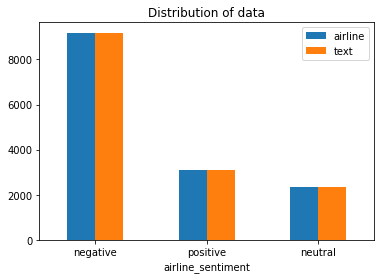

In [120]:
# Plotting the distribution for dataset.
ax = df.groupby('airline_sentiment').count().plot(kind='bar', title='Distribution of data',legend=True)
ax.set_xticklabels(['negative','positive','neutral'], rotation=0)
text, sentiment = list(df['text']), list(df['airline_sentiment'])

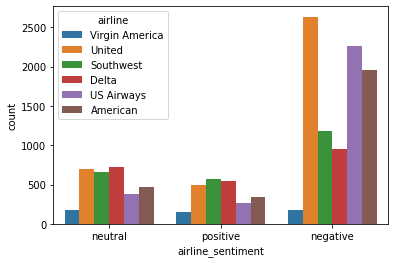

In [121]:
#drawing count-bar chart target class wise
ax = sns.countplot(x="airline_sentiment", hue="airline", data=df)

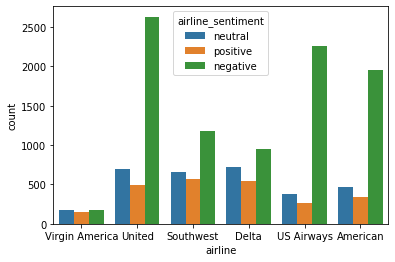

In [122]:
#drawing count-bar chart target airline wise
ax = sns.countplot(x="airline", hue="airline_sentiment", data=df)

**Data Preprocessing**

In [123]:
#taking relavant data
data=df[['text','airline_sentiment']]

In [124]:
#converting sentiment to numeric category using label encoder  
LE = LabelEncoder()
data['target'] = LE.fit_transform(df['airline_sentiment'])
data.head(2)


,text,airline_sentiment,target
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials t...,positive,2


In [125]:
#unique target values
data['target'].unique()

array([1, 2, 0])

In [126]:
#converting text to lower case
data['text']=data['text'].str.lower()
data['text'].head(2)

0                  @virginamerica what @dhepburn said.
1    @virginamerica plus you've added commercials t...
Name: text, dtype: object

In [127]:
#defining set of stopwords for removing for more efficient model. @source internet
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', "it's",'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve","you've", 'your', 'yours', 'yourself', 'yourselves',
             ]

In [128]:
#removing stopwords
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

0                       @virginamerica @dhepburn said.
1    @virginamerica plus added commercials experien...
2    @virginamerica didn't today... must mean need ...
3    @virginamerica really aggressive blast obnoxio...
4                  @virginamerica really big bad thing
Name: text, dtype: object

In [129]:
# removing URL’s
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].head()

0                       @virginamerica @dhepburn said.
1    @virginamerica plus added commercials experien...
2    @virginamerica didn't today... must mean need ...
3    @virginamerica really aggressive blast obnoxio...
4                  @virginamerica really big bad thing
Name: text, dtype: object

In [130]:
#removing punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations.replace("@","")
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

0                        @virginamerica @dhepburn said
1    @virginamerica plus added commercials experien...
2    @virginamerica didnt today must mean need take...
3    @virginamerica really aggressive blast obnoxio...
4                  @virginamerica really big bad thing
Name: text, dtype: object

In [131]:
#removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].head()

0                        @virginamerica @dhepburn said
1    @virginamerica plus added commercials experien...
2    @virginamerica didnt today must mean need take...
3    @virginamerica really aggressive blast obnoxio...
4                  @virginamerica really big bad thing
Name: text, dtype: object

In [132]:
#tokenization using tweet tokenizer 
#tweet tokenizer removes HTML code problematic characters, Twitter handles, and repeated letters.
tokenizer = TweetTokenizer(strip_handles=True)
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head(5)

0                                               [said]
1        [plus, added, commercials, experience, tacky]
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: text, dtype: object

In [133]:
#applying stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

0                                               [said]
1        [plus, added, commercials, experience, tacky]
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: text, dtype: object

In [134]:
#applying lemmetization
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

0                                               [said]
1        [plus, added, commercials, experience, tacky]
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: text, dtype: object

In [135]:
#complete preprocessing function
def preprocess_tweet(text):
  """
  this function takes an input string(tweet), applies all the preprocessing steps and returns tokenized data
  """
  #converting text to lower case
  text_lower=text.lower()
  #removing stopwords
  text_stop_words_removed=cleaning_stopwords(text_lower)
  # removing URL’s
  text_without_urls=cleaning_URLs(text_stop_words_removed)
  #removing punctuations
  text_without_punc=cleaning_punctuations(text_without_urls)
  #removing Numeric numbers
  text_without_nums=cleaning_numbers(text_without_punc)
  #tokenization using tweet tokenizer 
  tokenizer = TweetTokenizer(strip_handles=True)
  text_tokenized = tokenizer.tokenize(text_without_nums)
  #applying stemming
  text_stemmed=stemming_on_text(text_tokenized)
  #applying lemmetization
  text_lemma=lemmatizer_on_text(text_stemmed)
  return text_lemma

In [136]:
#defining X and y
X=data.text
y=data.target

**Splitting data into Train and Test Subset**

In [137]:
# Separating the 90% data for training data and 10% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =2)
 

In [138]:
#making TFIDF Vectorizer as it expects an array of strings. So if we pass it an array of arrays of tokenz, it crashes
X_train=X_train.apply(lambda x: ' '.join(x))
X_test=X_test.apply(lambda x: ' '.join(x))


In [139]:
X_train

14111                         everythings good brothaaaaaa
2645       thank much help birthday trip tickets confirmed
3488     updates dot looking united fares london us las...
3083      predawn flight miami ewr annual sobewff trip now
12561    not cool flight cancelled flightled sitting pl...
                               ...                        
11798    please hogs next flight me im waiting bus get ...
13896                             trouble getting rebooked
6637     eventually get but flight cancelled flightled ...
2575     flying home am event tomorrow pushed back flig...
7336     flight den jfk already hrs delayed idea might ...
Name: text, Length: 13176, dtype: object

**Transforming Dataset using TF-IDF Vectorizer**

In [140]:
#Fitting the TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  89325


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
#Transform the data using TF-IDF Vectorizer
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**Model building and Evaluation**

In [142]:
#function to evaluate trained model
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure()
  plot_confusion_matrix(cf_matrix, classes=['Negative','Positive','Neutral'],normalize=True,
                        title='Confusion matrix')

In [143]:
#function to plot confusion matrix for multi class target variable
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**MODEL1**

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       911
           1       0.87      0.04      0.08       324
           2       1.00      0.00      0.01       229

    accuracy                           0.63      1464
   macro avg       0.83      0.35      0.29      1464
weighted avg       0.74      0.63      0.50      1464

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.95987654 0.04012346 0.        ]
 [0.98689956 0.00873362 0.00436681]]


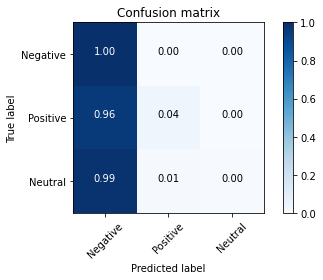

In [144]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred2 = BNBmodel.predict(X_test)

**MODEL2**

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       911
           1       0.68      0.45      0.54       324
           2       0.73      0.71      0.72       229

    accuracy                           0.79      1464
   macro avg       0.75      0.69      0.71      1464
weighted avg       0.78      0.79      0.77      1464

Normalized confusion matrix
[[0.92645445 0.05159166 0.0219539 ]
 [0.43209877 0.44753086 0.12037037]
 [0.20524017 0.08733624 0.70742358]]


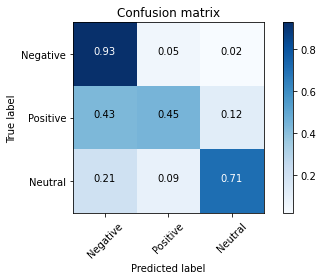

In [145]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

**MODEL3**

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       911
           1       0.76      0.43      0.55       324
           2       0.75      0.67      0.71       229

    accuracy                           0.79      1464
   macro avg       0.77      0.68      0.71      1464
weighted avg       0.78      0.79      0.77      1464

Normalized confusion matrix
[[0.94291987 0.03402854 0.02305159]
 [0.48148148 0.42901235 0.08950617]
 [0.27510917 0.05676856 0.66812227]]


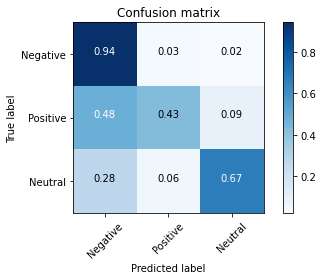

In [146]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [147]:
#for now concluding LR to be best model based on current performance metrics.
#tuning 
#next steps--using BERT models pretrained on tweets , 
#better to pretrain, finetune also on airline related tweets. 

In [148]:
#function to find sentiment realtime using above trained LR model-
def predict_tweet_sentiment(sample_tweet):
  preprocessed_tweet=preprocess_tweet(sample_tweet)
  df_test = pd.DataFrame({'text':preprocessed_tweet})
  df_test = df_test.apply(lambda x: ' '.join(x))
  df_test = vectoriser.transform(df_test)
  test_pred = LRmodel.predict(df_test)
  if test_pred[0]==0:
    return "negative"
  elif test_pred[0]==2:
    return "positive"
  else:
    return "neutral"

In [149]:
#sample tweets to test the trained model
sample1="realy hated the flying experience of indigo airways @indigohandle"
sample2="realy loved the flying experience of jet2 airways @jet2handle"

In [150]:
predict_tweet_sentiment(sample1)

'negative'

In [151]:
predict_tweet_sentiment(sample2)

'positive'

**Finding themes behind negative tweets/topic modelling**

In [152]:
#negative sentiment = target variable = 0
negative_sentiment_data_df=data.text[data.target==0]

In [153]:
#negative sentiment data
negative_sentiment_data_df

3        [really, aggressive, blast, obnoxious, enterta...
4                                [really, big, bad, thing]
5        [seriously, would, pay, flight, seats, didnt, ...
15                          [sfopdx, schedule, still, mia]
17       [flew, nyc, sfo, last, week, couldnt, fully, s...
                               ...                        
14631    [thx, nothing, getting, us, country, back, us,...
14633    [flight, cancelled, flightled, leaving, tomorr...
14634                              [right, cue, delays, 👌]
14636    [leaving, over, minutes, late, flight, no, war...
14638    [money, change, flight, dont, answer, phones, ...
Name: text, Length: 9178, dtype: object

In [154]:
#preparing negative sentiment data corpus that is already tokenized, preprocessed thoroughly
processed_data = []
processed_data = negative_sentiment_data_df.tolist()
processed_data[:2]

[['really',
  'aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'guests',
  'faces',
  'amp',
  'little',
  'recourse'],
 ['really', 'big', 'bad', 'thing']]

In [155]:
#Create a dictionary from 'processed_data' containing the number of times a word appears in the training set
dictionary = gensim.corpora.Dictionary(processed_data)

In [156]:
# Remove very rare and very common words:
# words appearing less than 15 times
# words appearing in more than 10% of all documents
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)


In [157]:
#for each document we create a dictionary reporting how many words and how many times those words appear
bow_corpus = [dictionary.doc2bow(pd) for pd in processed_data]

In [158]:
#Preview BOW for our sample preprocessed data
document_num = 10
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 62 ("cant") appears 1 time.
Word 64 ("add") appears 1 time.
Word 65 ("birthday") appears 1 time.
Word 66 ("booking") appears 1 time.
Word 67 ("cause") appears 1 time.
Word 68 ("cool") appears 1 time.
Word 69 ("hi") appears 1 time.
Word 70 ("middle") appears 1 time.
Word 71 ("name") appears 1 time.
Word 72 ("problems") appears 1 time.
Word 73 ("trip") appears 1 time.
Word 74 ("you") appears 1 time.


In [159]:
#Training lda model using gensim.models.LdaMulticore; finding top 10 topics(themes behind negative tweets)
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [160]:
#For each topic, printing the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.062*"call" + 0.053*"back" + 0.024*"time" + 0.021*"hold" + 0.019*"let" + 0.017*"system" + 0.017*"called" + 0.013*"hours" + 0.012*"off" + 0.012*"take"


Topic: 1 
Words: 0.018*"delay" + 0.017*"plane" + 0.015*"going" + 0.015*"late" + 0.014*"gate" + 0.014*"’" + 0.014*"min" + 0.013*"delayed" + 0.012*"understand" + 0.011*"call"


Topic: 2 
Words: 0.045*"service" + 0.037*"customer" + 0.019*"airport" + 0.015*"us" + 0.015*"im" + 0.015*"rude" + 0.015*"minutes" + 0.014*"line" + 0.014*"gate" + 0.012*"people"


Topic: 3 
Words: 0.021*"still" + 0.018*"bag" + 0.018*"im" + 0.014*"seat" + 0.014*"know" + 0.014*"guys" + 0.012*"hours" + 0.012*"could" + 0.011*"you" + 0.010*"make"


Topic: 4 
Words: 0.032*"hours" + 0.025*"thanks" + 0.025*"would" + 0.017*"told" + 0.016*"hour" + 0.015*"plane" + 0.014*"wait" + 0.013*"us" + 0.013*"yes" + 0.013*"said"


Topic: 5 
Words: 0.045*"service" + 0.036*"customer" + 0.024*"ever" + 0.023*"worst" + 0.017*"experience" + 0.017*"never" + 0.016*"airline" + 0.

#Probable Topics learnt (from previous cell output)
0: Calling hold/wait time

1: help needed on cancellations

2: long waiting hours at airport / gate

3: flight delays

4: flight late

5: luggage wait time

6: airport/hotel night stay

7: fligh cancellations/rebooking

8: bad customer service

9: issue with phone calls


In [161]:
#realtime checking for theme/topic 
def get_sentiment_theme(input_tweet):
  '''
  returns the score for the above 10 topics, sorted in descending, most related being the 1st one
  '''
  #the maximum score above is of the matched topic (1st row of the result)
  bow_vector = dictionary.doc2bow(preprocess_tweet(input_tweet))
  for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
      print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 8)))


In [168]:
#sample tweets for predicting topic/theme
tweet1="I was waiting for luggage to arive for 10 hours."
tweet2="I am feeling bad as the customer service person keeps call on hold for hours . "
tweet3="My flight has been delayed for 2 hours. I am very disappointed by the @indogo airline"

In [169]:
get_sentiment_theme(tweet1)

Score: 0.7749807238578796	 Topic: 0.107*"cancelled" + 0.051*"flightled" + 0.028*"flighted" + 0.026*"flights" + 0.019*"waiting" + 0.019*"hours" + 0.018*"tomorrow" + 0.016*"amp"
Score: 0.025006407871842384	 Topic: 0.032*"hours" + 0.025*"thanks" + 0.025*"would" + 0.017*"told" + 0.016*"hour" + 0.015*"plane" + 0.014*"wait" + 0.013*"us"
Score: 0.025002695620059967	 Topic: 0.056*"help" + 0.034*"phone" + 0.024*"please" + 0.023*"email" + 0.019*"cancelled" + 0.016*"someone" + 0.015*"one" + 0.015*"speak"
Score: 0.025002513080835342	 Topic: 0.062*"call" + 0.053*"back" + 0.024*"time" + 0.021*"hold" + 0.019*"let" + 0.017*"system" + 0.017*"called" + 0.013*"hours"
Score: 0.025002293288707733	 Topic: 0.045*"service" + 0.037*"customer" + 0.019*"airport" + 0.015*"us" + 0.015*"im" + 0.015*"rude" + 0.015*"minutes" + 0.014*"line"
Score: 0.02500188909471035	 Topic: 0.021*"still" + 0.018*"bag" + 0.018*"im" + 0.014*"seat" + 0.014*"know" + 0.014*"guys" + 0.012*"hours" + 0.012*"could"
Score: 0.025001348927617073

In [170]:
get_sentiment_theme(tweet2)

Score: 0.4609377086162567	 Topic: 0.062*"call" + 0.053*"back" + 0.024*"time" + 0.021*"hold" + 0.019*"let" + 0.017*"system" + 0.017*"called" + 0.013*"hours"
Score: 0.45015478134155273	 Topic: 0.045*"service" + 0.036*"customer" + 0.024*"ever" + 0.023*"worst" + 0.017*"experience" + 0.017*"never" + 0.016*"airline" + 0.013*"seats"
Score: 0.011116456240415573	 Topic: 0.056*"help" + 0.034*"phone" + 0.024*"please" + 0.023*"email" + 0.019*"cancelled" + 0.016*"someone" + 0.015*"one" + 0.015*"speak"
Score: 0.011114138178527355	 Topic: 0.045*"service" + 0.037*"customer" + 0.019*"airport" + 0.015*"us" + 0.015*"im" + 0.015*"rude" + 0.015*"minutes" + 0.014*"line"
Score: 0.011113673448562622	 Topic: 0.032*"hours" + 0.025*"thanks" + 0.025*"would" + 0.017*"told" + 0.016*"hour" + 0.015*"plane" + 0.014*"wait" + 0.013*"us"
Score: 0.0111134834587574	 Topic: 0.057*"cant" + 0.025*"hold" + 0.022*"help" + 0.022*"online" + 0.020*"change" + 0.020*"phone" + 0.015*"website" + 0.013*"trying"
Score: 0.011113054119050

In [171]:
get_sentiment_theme(tweet3)

Score: 0.3064354360103607	 Topic: 0.032*"hours" + 0.025*"thanks" + 0.025*"would" + 0.017*"told" + 0.016*"hour" + 0.015*"plane" + 0.014*"wait" + 0.013*"us"
Score: 0.2783873677253723	 Topic: 0.029*"like" + 0.026*"bag" + 0.021*"aa" + 0.021*"problems" + 0.017*"need" + 0.015*"help" + 0.014*"booking" + 0.013*"never"
Score: 0.27514517307281494	 Topic: 0.045*"service" + 0.037*"customer" + 0.019*"airport" + 0.015*"us" + 0.015*"im" + 0.015*"rude" + 0.015*"minutes" + 0.014*"line"
Score: 0.020009813830256462	 Topic: 0.045*"service" + 0.036*"customer" + 0.024*"ever" + 0.023*"worst" + 0.017*"experience" + 0.017*"never" + 0.016*"airline" + 0.013*"seats"
Score: 0.020006589591503143	 Topic: 0.107*"cancelled" + 0.051*"flightled" + 0.028*"flighted" + 0.026*"flights" + 0.019*"waiting" + 0.019*"hours" + 0.018*"tomorrow" + 0.016*"amp"
Score: 0.02000541426241398	 Topic: 0.018*"delay" + 0.017*"plane" + 0.015*"going" + 0.015*"late" + 0.014*"gate" + 0.014*"’" + 0.014*"min" + 0.013*"delayed"
Score: 0.02000338770